In [3]:
import sys
sys.path.append(
    "/Users/shenshen/drake-build/install/lib/python3.7/site-packages")
import math
import pydrake
import numpy as np
from numpy.linalg import eig, inv
from pydrake.all import (MathematicalProgram, Polynomial,
                         Expression, SolutionResult,
                         Variables, Solve, Jacobian, Evaluate,
                         RealContinuousLyapunovEquation, Substitute,
                         MosekSolver, MonomialBasis)
from veril import closed_loop
import warnings; warnings.simplefilter('ignore') #some keras warning about future compatibility
from veril.util import plots

In [4]:
sys_name = 'VanderPol'
max_deg = 3 #so degV=6
system = closed_loop.get(sys_name)
system.set_features(max_deg)

I tried three variations of formulation, in two groups of experiements. 

The formulation varies depending on whether or not we add $P\succ 0$ explicitly, and whether use the constraint: $V+\dot V \leq \alpha$ or simply $\dot V \leq \alpha$. Ideally, we hope to get a PSD $P$ matrix, and a strongly negative slack.

The experiement group varies depending on if we feed all possible stable samples, or just a subset.

- Formulation 1:
$$
\begin{array}{l}{\min \alpha} \\ {\text { s.t. }\left\{\begin{array}{l}
{V_i + \dot{V}_i \leq \alpha}  \quad {\forall i} \\ 
{V_{i}=\phi_{i}^{\prime} P \phi_{i} \geqslant 0 \quad \forall i} \\ {V(1)=1}\end{array}\right.}\end{array}
$$

- Formulation 2:
$$
\begin{array}{l}{\min \alpha} \\ {\text { s.t. }\left\{\begin{array}{l}
{\dot{V}_i \leq \alpha}  \quad {\forall i} \\ 
{V_{i}=\phi_{i}^{\prime} P \phi_{i} \geqslant 0 \quad \forall i} \\ {V(1)=1}\end{array}\right.}\end{array}
$$

- Formulation 3:
$$
\begin{array}{l}{\min \alpha} \\ {\text { s.t. }\left\{\begin{array}{l}
{\dot{V}_i \leq \alpha}  \quad {\forall i} \\ 
{V(1)=1}\\ P \succ 0\end{array}\right.}\end{array}
$$

In [5]:
def search_for_P(sampled_quantities, PSD_constrained=True, vdot_only = True, verbose=False):
    phi, dphidx, f = sampled_quantities
    monomial_dim = phi.shape[-1]
    one_vec = np.ones(monomial_dim)

    prog = MathematicalProgram()
    P = prog.NewSymmetricContinuousVariables(monomial_dim, "P")
    slack = prog.NewContinuousVariables(1, "s")[0]
    num_samples = phi.shape[0]
    if PSD_constrained:
        prog.AddPositiveSemidefiniteConstraint(P)

    for i in range(num_samples):
        this_v = phi[i, :].T@P@phi[i, :]
        if not PSD_constrained:
            prog.AddConstraint(this_v >= 0)
        this_vdot = phi[i, :].T@P@dphidx[i, :, :]@f[i, :]
        if vdot_only:
            prog.AddConstraint(this_vdot <= slack)
        else:
            prog.AddConstraint(this_v + this_vdot <= slack)

    prog.AddConstraint(one_vec.T@P@one_vec == 1)
    prog.AddCost(slack)
    solver = MosekSolver()
    solver.set_stream_logging(True, "lp-logs.txt")
    result = solver.Solve(prog, None, None)
    print(result.get_solution_result())
    assert result.is_success()
    P = result.GetSolution(P)
    slack = result.GetSolution(slack)
    print('eig of P  %s' % (eig(P)[0]))
    print('slack value %s' %slack)
    if verbose:
        myfile = open("lp-logs.txt")
        print(myfile.read())
        myfile.close()
    return P

def VV(system,P):
    V = system.sym_phi.T@P@system.sym_phi
    return plots.plot3d(V, sys_name, system.slice, r_max=2, add_title='')

# Group 1: use all possible stable samples (14896 samples)

In [7]:
file_path = '../data/' + sys_name + '/train_for_v_features'+str(max_deg)+'.npz'
loaded = np.load(file_path)
sampled_quantities = [loaded['phi'], loaded['dphidx'], loaded['f']]

### - Formulation 1, LP, on all samples
The first formulation returned non-PSD $P$ matrix and a positive slack. So not promising.

In [8]:
P11 = search_for_P(sampled_quantities, PSD_constrained=False, vdot_only =False)

SolutionResult.kSolutionFound
eig of P  [ 9.99999864e-01  3.05127376e-08  2.12977348e-08 -3.06158627e-08
 -2.98021877e-08 -1.98880832e-08  8.17093745e-09 -1.71627019e-09
  2.27721865e-09  1.01556856e-09]
slack value 1.0000000003064993


### - Formulation 2, LP, on all samples
The second formulation also returns non-PSD $P$ matrix.

In [13]:
P12 = search_for_P(sampled_quantities, PSD_constrained=False, vdot_only =True)

SolutionResult.kSolutionFound
eig of P  [ 3.04141865e+00 -1.60178290e+00  1.82550066e+00 -6.83539895e-01
  9.07213325e-01  6.08403897e-01 -2.87296794e-01  7.28477174e-02
 -1.25903057e-03  2.87111857e-01]
slack value -0.0003339393675913135


### - Formulation 3, SDP, on all samples (14897 constraints, PSD constraint size 10)
The thrid formulation took more than 8 minutes...

In [35]:
P13 = search_for_P(sampled_quantities, PSD_constrained=True, vdot_only =True, verbose=True)

SolutionResult.kSolutionFound
eig of P  [3.69964079e+00 9.26280835e-01 7.11142255e-01 2.34510479e-01
 1.59292517e-01 1.36597524e-01 1.03144161e-01 2.24958158e-03
 3.59464393e-05 1.52267868e-06]
slack value -0.00032779677128877687

File opened at Tue Dec 17 22:09:24 2019 by MOSEK version 9.0.96.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 14897           
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 

In [31]:
V13 = system.sym_phi.T@P13@system.sym_phi

<IPython.core.display.Javascript object>


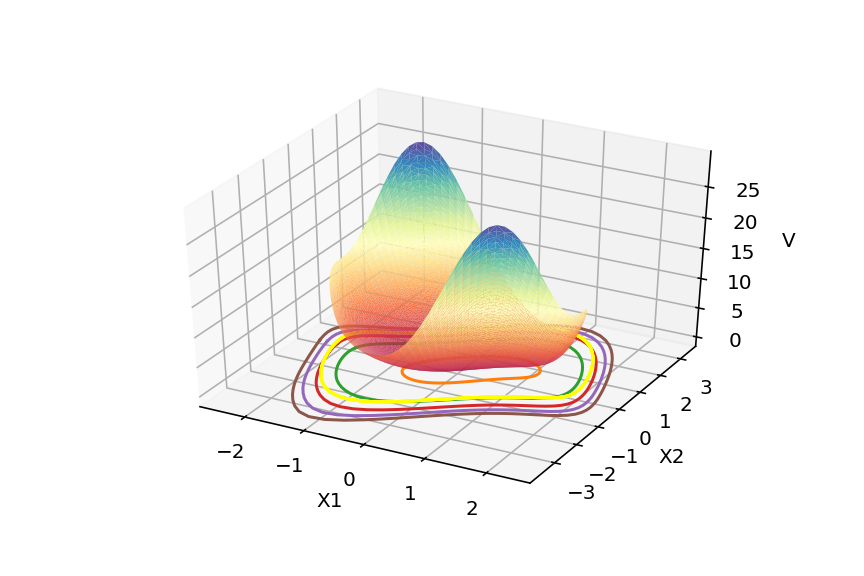

In [32]:
%matplotlib notebook
plots.plot3d(V13, sys_name, system.slice, r_max=2, add_title='')

# 2 group: use only a subset of samples: (3601 samples)

In [16]:
file_path = '../data/' + sys_name + '/lp_for_v_features'+str(max_deg)+'.npz'
loaded = np.load(file_path)
sampled_x, sampled_quantities = [loaded['x'],[loaded['phi'], loaded['dphidx'], loaded['f']]]

<IPython.core.display.Javascript object>


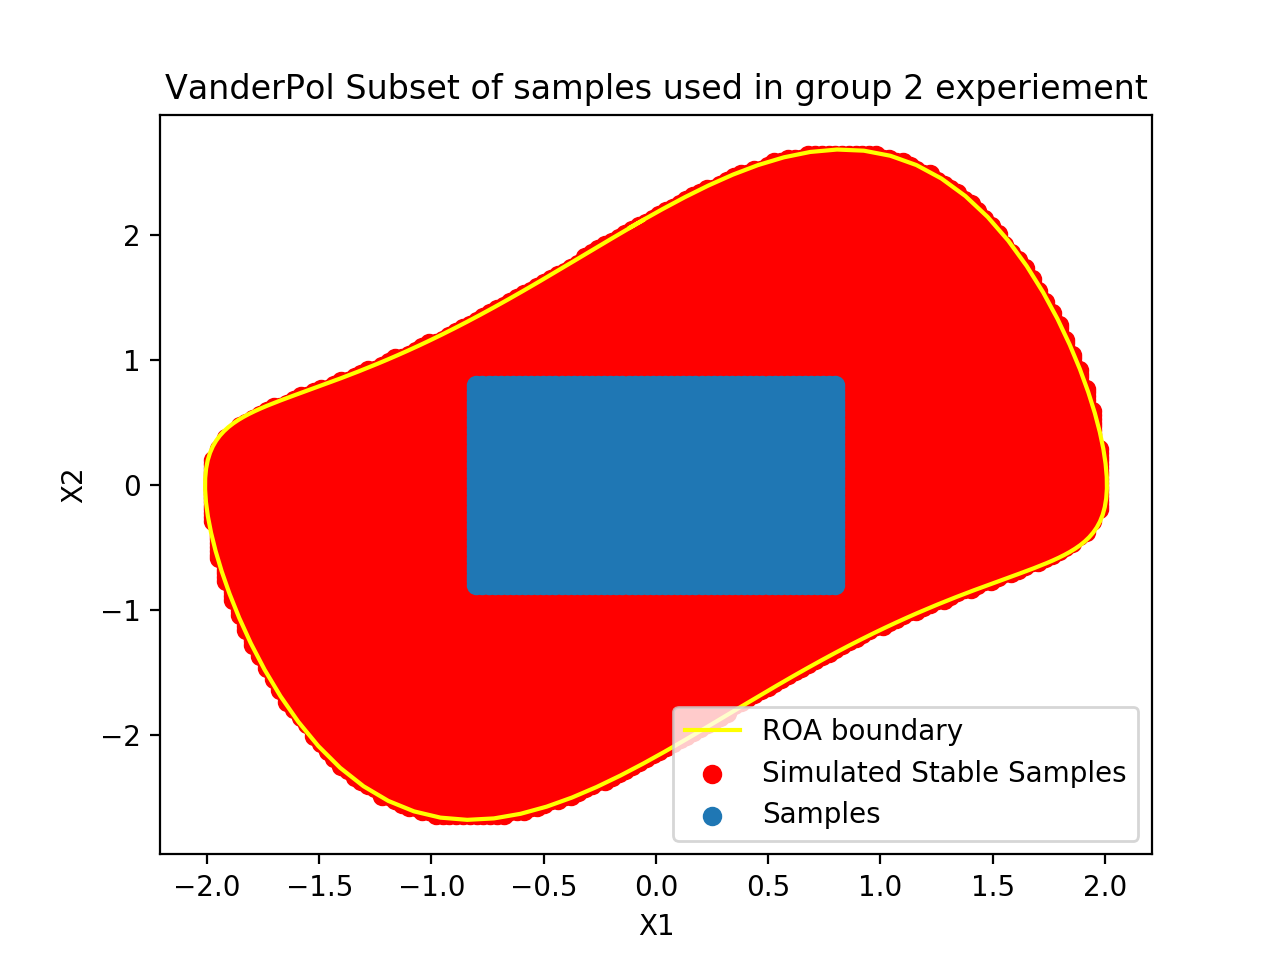

In [17]:
%matplotlib notebook
plots.scatterSamples(sampled_x, sys_name, [0,1], add_title='Subset of samples used in group 2 experiement')

### - Formulation 1, LP, on smaller set of samples
The first LP formulation, on this smaller set of samples, still returns a non-PSD $P$ matrix and positive slack. 

In [18]:
P21 = search_for_P(sampled_quantities, PSD_constrained=False, vdot_only =False)

SolutionResult.kSolutionFound
eig of P  [ 4.49968415e+00 -1.88933349e+00  9.99377472e-01  2.00732725e-01
  1.45705138e-02 -1.40225529e-02 -4.10418491e-03  2.46905085e-05
  8.07507817e-06 -1.82006251e-08]
slack value 8.304770911458788e-08


### - Formulation 2, LP, on smaller set of samples
The second LP formulation also returns non-PSD $P$ matrix.

In [19]:
P22 = search_for_P(sampled_quantities, PSD_constrained=False, vdot_only =True)

SolutionResult.kSolutionFound
eig of P  [-1.81198133e+00  1.11870720e+00 -7.18514674e-01  3.49690855e-01
  3.10668604e-01  2.78541814e-01 -1.96950834e-01 -1.52294528e-01
  2.55765461e-03  5.30732840e-08]
slack value -0.0


### - Formulation 3, SDP, on smaller set of samples (3601 constraints, PSD constraint size 10)

In [13]:
P23 = search_for_P(sampled_quantities, PSD_constrained=True, vdot_only =True, verbose=True)

SolutionResult.kSolutionFound
eig of P  [3.52215594 1.29565554 0.24024683 0.16448318 0.16894257 0.1050818
 0.03364915 0.07000453 0.05646828 0.04998629]
slack value -4.0718829056548874e-14

File opened at Tue Dec 17 21:45:49 2019 by MOSEK version 9.0.96.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3601            
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   :

As expected, the comutation is much faster. However, the shape of $V$ seems to overfit this smaller sample set.

<IPython.core.display.Javascript object>


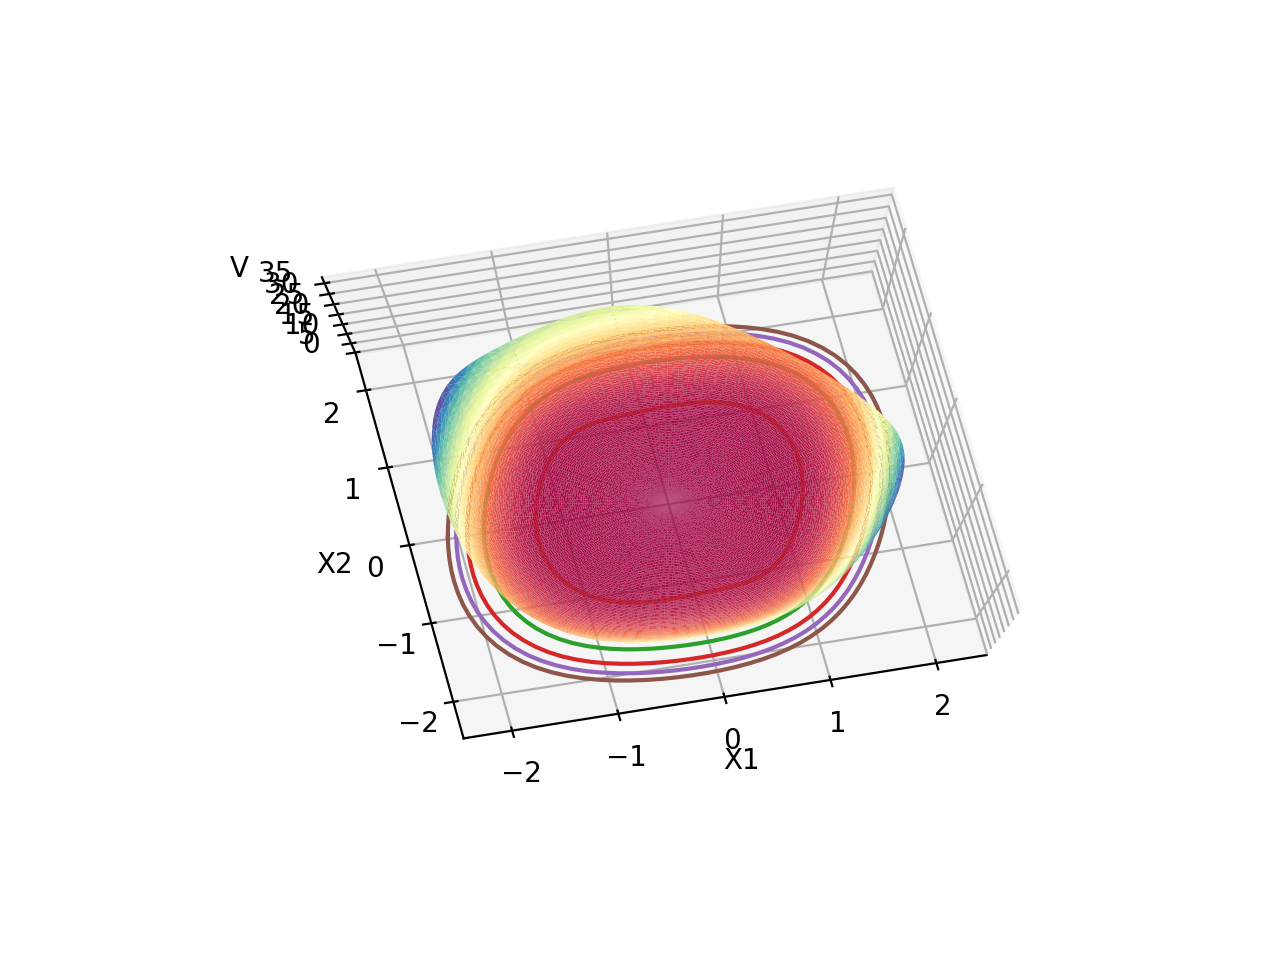

In [34]:
V23 = system.sym_phi.T@P23@system.sym_phi
%matplotlib notebook
plots.plot3d(V23, sys_name, system.slice, r_max=2, add_title='')